# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Salary Predictions

In [3]:
#import your libraries
import pandas as pd
import numpy as np
import sklearn as sk
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
#etc

#your info here
#__author__ = "your name here"
#__email__ = "your email here"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [4]:
#load the data into a Pandas dataframe
features = pd.read_csv('train_features.csv')
target = pd.read_csv('train_salaries.csv')
test_data = pd.read_csv('test_features.csv')

### ---- 3 Clean the data ----

In [5]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
features.isnull().sum()


jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [6]:
#check if the target variable salary has nulls
target.isnull().sum()


jobId     0
salary    0
dtype: int64

In [7]:
listoffeatures = ['companyId', 'jobType', 'degree', 'major', 'industry','yearsExperience']
for i in listoffeatures:
    a = features[i].unique()
    print(a)

['COMP37' 'COMP19' 'COMP52' 'COMP38' 'COMP7' 'COMP15' 'COMP24' 'COMP20'
 'COMP41' 'COMP56' 'COMP4' 'COMP54' 'COMP57' 'COMP14' 'COMP61' 'COMP58'
 'COMP3' 'COMP44' 'COMP30' 'COMP27' 'COMP34' 'COMP11' 'COMP31' 'COMP49'
 'COMP0' 'COMP1' 'COMP36' 'COMP47' 'COMP8' 'COMP42' 'COMP50' 'COMP53'
 'COMP48' 'COMP45' 'COMP46' 'COMP2' 'COMP5' 'COMP55' 'COMP29' 'COMP40'
 'COMP33' 'COMP22' 'COMP12' 'COMP25' 'COMP6' 'COMP23' 'COMP17' 'COMP28'
 'COMP21' 'COMP26' 'COMP43' 'COMP51' 'COMP10' 'COMP59' 'COMP13' 'COMP39'
 'COMP16' 'COMP9' 'COMP32' 'COMP62' 'COMP35' 'COMP18' 'COMP60']
['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']
['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']
['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']
['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']
[10  3  8  2 23  9  1 17 24  7 21 13 11 14 18 20 12 15 22  0 19  5  4 16
  6]


In [8]:
features['degree'] = features['degree'].replace(['NONE'], 'OTHER')
features['major'] = features['major'].replace(['NONE'], 'OTHER')


In [9]:
filterdf = features['degree'] == 'NONE'


In [10]:
jobTypedf = features[filterdf]
jobTypedf.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


(array([2.45200e+03, 6.55490e+04, 1.99948e+05, 2.99777e+05, 2.46632e+05,
        1.27603e+05, 4.52460e+04, 1.10070e+04, 1.65700e+03, 1.29000e+02]),
 array([  0. ,  30.1,  60.2,  90.3, 120.4, 150.5, 180.6, 210.7, 240.8,
        270.9, 301. ]),
 <a list of 10 Patch objects>)

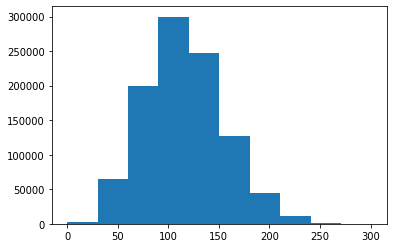

In [11]:

plt.hist(target['salary'])

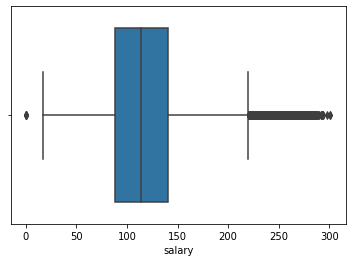

In [12]:
sns.boxplot(target['salary'])

From the above box plot we see there are zeros in the salary column

In [13]:
zeroSalary = target['salary'] == 0
zeroSalarydf = target[zeroSalary]
zeroSalarydf

,jobId,salary
30559,JOB1362684438246,0
495984,JOB1362684903671,0
652076,JOB1362685059763,0
816129,JOB1362685223816,0
828156,JOB1362685235843,0


In [14]:
#merging the features and the target dataset to get on whole dataset
merge = pd.merge(features, target, left_on='jobId', right_on='jobId')


In [15]:
#removing the rows with salary zero
features_target = merge[merge.salary != 0]



In [16]:
#check for the number of unique values in each variable
for col in features_target.columns:
    print( col ,':', len(features_target[col].unique()))

jobId : 999995
companyId : 63
jobType : 8
degree : 5
major : 9
industry : 7
yearsExperience : 25
milesFromMetropolis : 100
salary : 279


In [17]:
# remove job id as it is not necessary as it has a unique value for every row
training_data = features_target.drop('jobId',axis=1)

In [18]:
training_data.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,OTHER,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


# Interquartile range (IQR) to identify the outliers

In [19]:
#function to check for the upper and lower quartile of outliers
def search_outliers(dataframe,feature=None):
    percentile = dataframe[feature].describe()
    IQR = percentile['75%'] - percentile['25%']
    upper_percentile = percentile['75%'] + 1.5*IQR
    lower_percentile = percentile['25%'] - 1.5*IQR
    print(upper_percentile,lower_percentile)

In [20]:
search_outliers(training_data,"salary")

220.5 8.5


In [21]:
training_data[training_data['salary']>220.5]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,COMP38,CTO,MASTERS,OTHER,HEALTH,24,3,223
560,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225
966,COMP32,CEO,DOCTORAL,ENGINEERING,FINANCE,23,11,247
986,COMP37,CFO,HIGH_SCHOOL,OTHER,FINANCE,24,20,229
1211,COMP24,CTO,DOCTORAL,BUSINESS,FINANCE,5,46,232
1222,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
1413,COMP56,VICE_PRESIDENT,MASTERS,MATH,WEB,24,15,241


There are no salaries which are less than 8.5

In [22]:
#removing rows which have salaries > 220.5
training_data[training_data['salary']<220.5]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,OTHER,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,COMP15,CFO,OTHER,OTHER,HEALTH,23,24,178
7,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,COMP20,JANITOR,HIGH_SCHOOL,OTHER,EDUCATION,1,54,31
9,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


### ---- 4 Explore the data (EDA) ----

In [21]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

In [23]:
#use of initial merged dataframe to explore the data and to analyze
features_target.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,OTHER,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [24]:
#check for the coorelation between the nominal variables in the dataset with target
features_target[features_target.columns[1:]].corr()['salary'][:]

yearsExperience        0.375013
milesFromMetropolis   -0.297686
salary                 1.000000
Name: salary, dtype: float64

In [28]:
#plotting bar graphs with different categorical variables against salary
def bar_graph(feat):
    for feature in feat:
        dim = (11, 6)
        fig, ax = plt.subplots(figsize=dim)
        degree = features_target.groupby([feature]).mean().salary.reset_index(name='income')
        sns.barplot(x=degree[feature],y= degree['income'])
        plt.show()

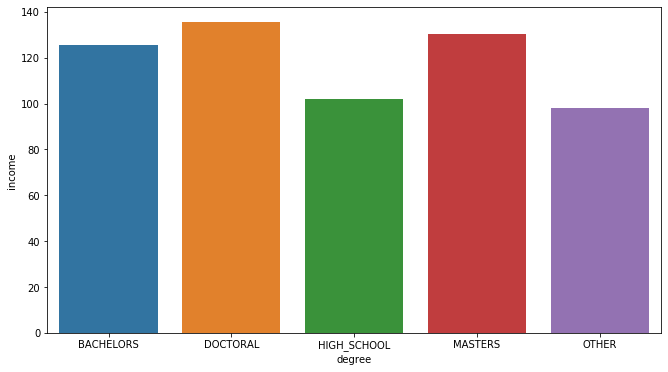

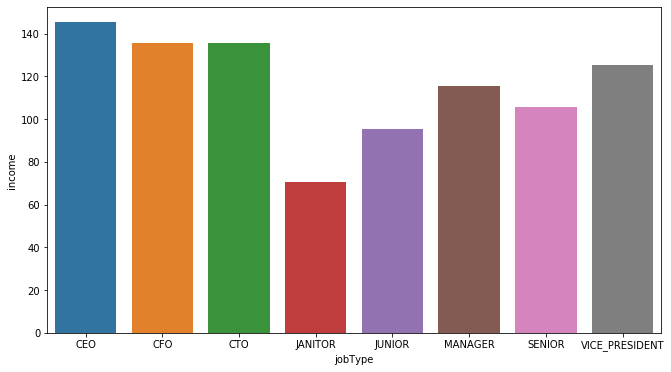

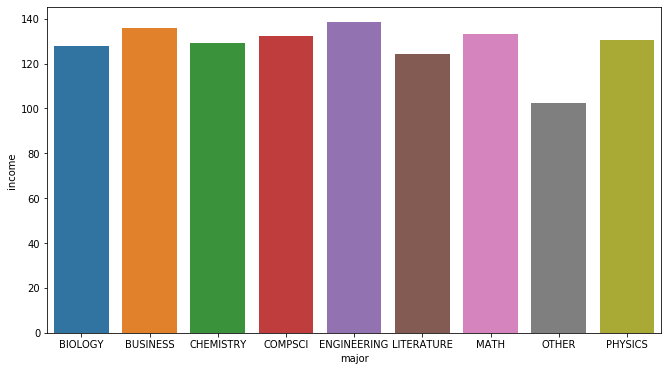

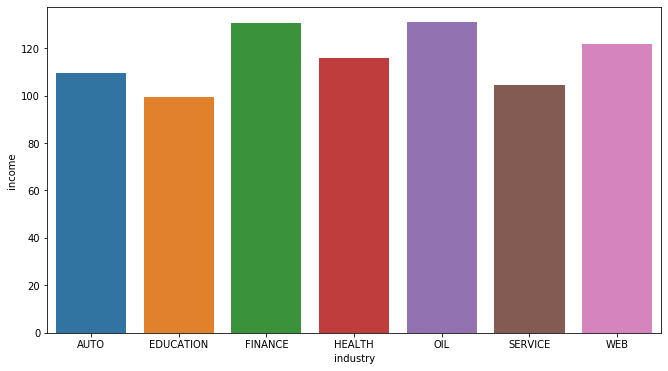

In [29]:
feat = ['degree','jobType','major','industry']
bar_graph(feat)

From the above plots we see that people having doctral and masters are paid higher salaries compared to others. 
Salaries also change as the position changes

In [34]:
# box plot to compare ordinal values with the target
def box_plot(feat):
    for col in feat:
        dim = (15, 6)
        fig, ax = plt.subplots(figsize=dim)
        sns.boxplot(x=col,y= 'salary', data=features_target.sort_values('salary'))
        plt.xticks(rotation =90)
        plt.show()

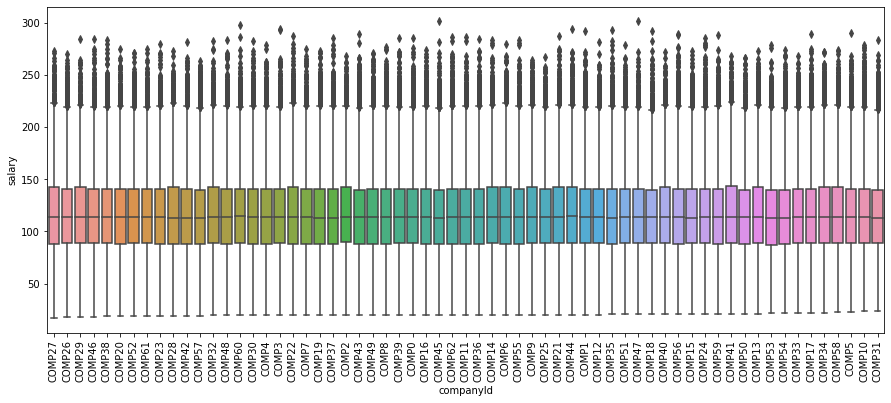

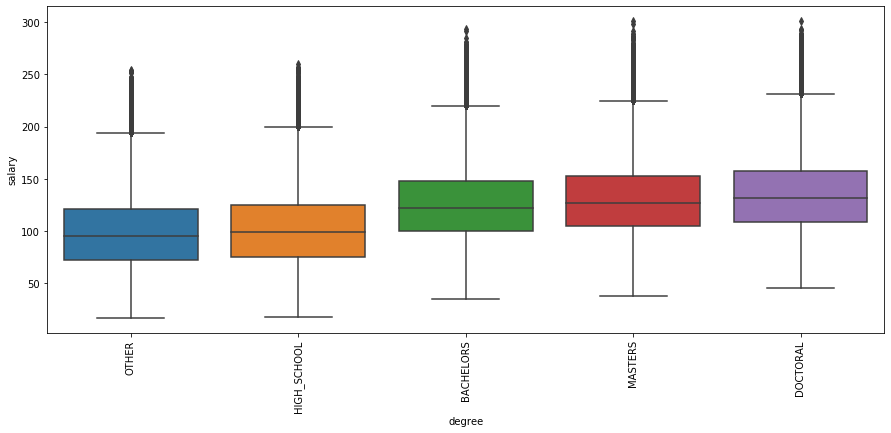

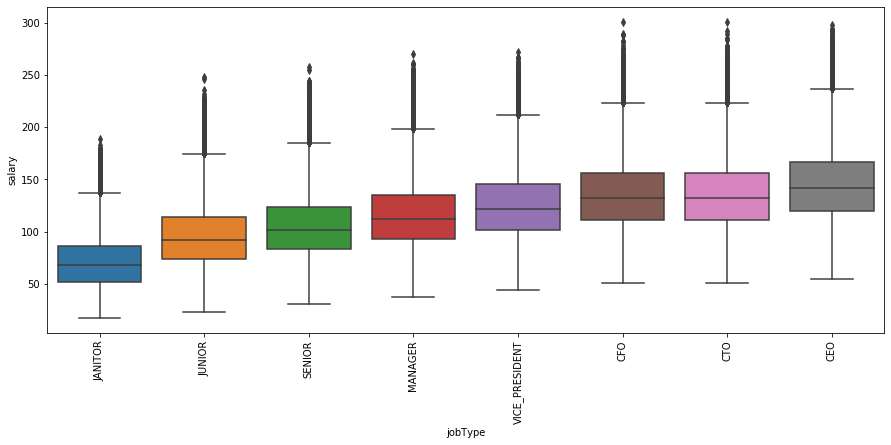

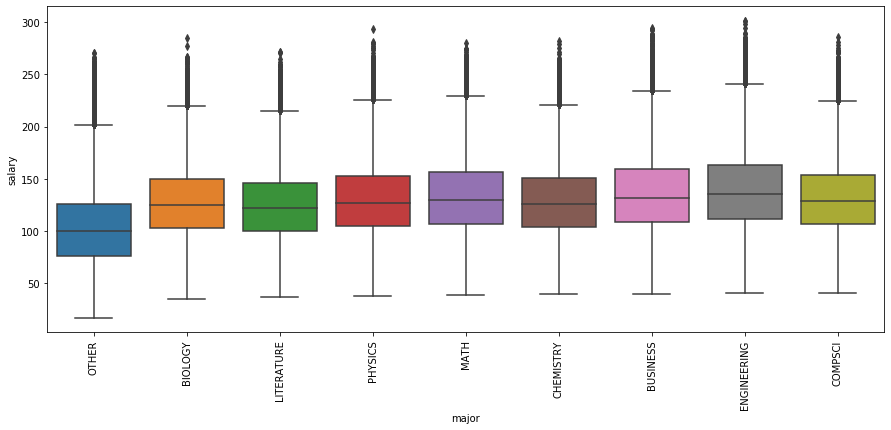

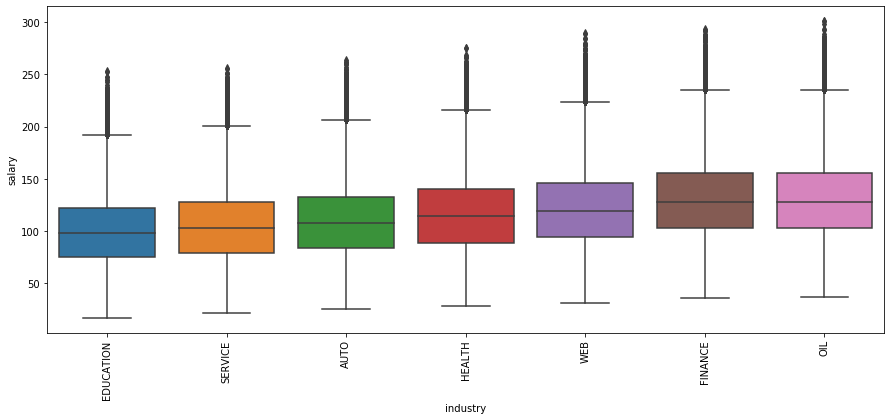

In [35]:
feat = ['companyId','degree','jobType','major','industry']
box_plot(feat)

From the box plot of Company Id vs salary we can see there is not much variance among the different company ids, hence the column can be ignored

In [28]:

def line_plot(feature_list):
    for i in feature_list:
        dim = (11,6)
        fig, ax = plt.subplots(figsize=dim)
        experience = features_target.groupby([i]).mean().salary.reset_index(name = 'income')
        sns.lineplot(x=experience[i],y=experience['income'] )
        plt.show()

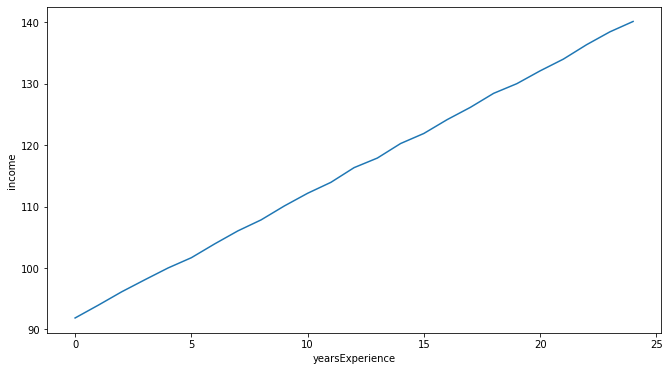

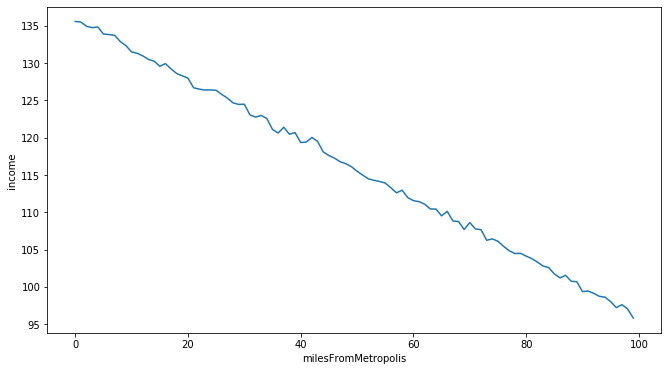

In [29]:
l = ['yearsExperience','milesFromMetropolis']
line_plot(l)

From the line plots above we can see that salary increases as  Years of Experience increases, whereas salary decreases as Miles from metropolis increases

In [30]:
training_data.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,OTHER,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [31]:
def build_heat_map(col1,col2):
    df_gptest = training_data[[col1,col2,'salary']]
    grouped_test1 = df_gptest.groupby([col1,col2],as_index=False).mean()
    grouped_pivot = grouped_test1.pivot(index=col1,columns=col2)
    grouped_pivot = grouped_pivot.fillna(0)
    fig, ax = plt.subplots()
    im = ax.pcolor(grouped_pivot, cmap='seismic')
    row_labels = grouped_pivot.columns.levels[1]
    col_labels = grouped_pivot.index
    ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)    
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(col_labels, minor=False)
    fig.colorbar(im)
    plt.xticks(rotation=90)


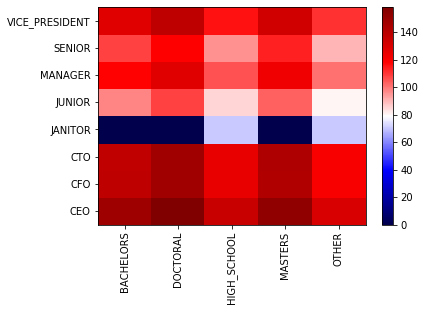

In [32]:
build_heat_map('jobType','degree')


We see from the above heatmap that employees who have a doctral and are in C-level positions

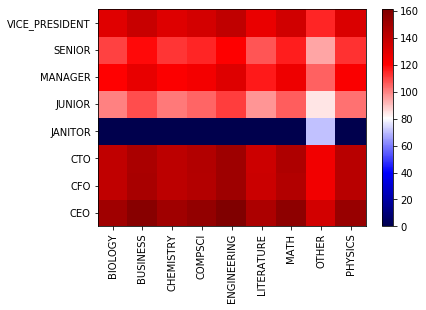

In [33]:
build_heat_map('jobType','major')


From the above heatmap we see that salary is dependent mainly on the job type and not the major

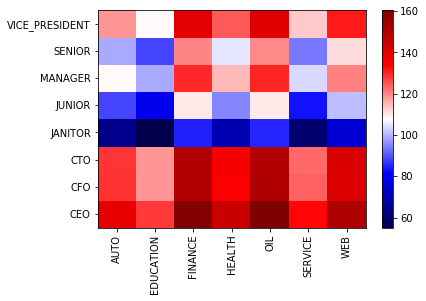

In [34]:
build_heat_map('jobType','industry')


C level executives from finance, oil and web industries are paid more

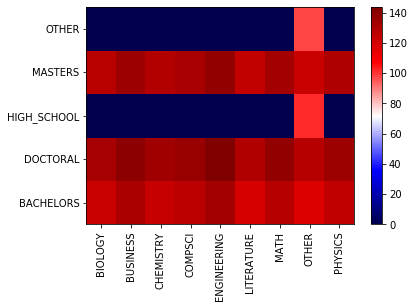

In [35]:
build_heat_map('degree','major')


From the heat map we see that employees who have done masters and doctral are paid higher salaries compared to other degrees

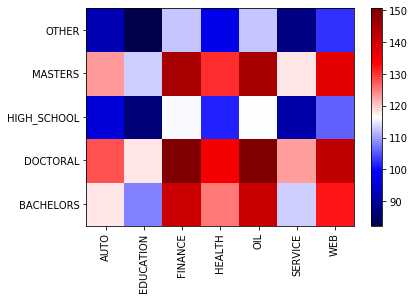

In [36]:
build_heat_map('degree','industry')


Employees with doctrals and working in finance and oil industry are paid more.

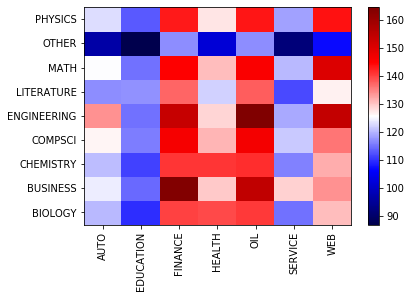

In [37]:
build_heat_map('major','industry')


Irrespective of the major, employees in the finance and oil industry are paid more

### ---- 5 Establish a baseline ----

In [38]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy

In [39]:
#calculate the average salary for each industry
income_industry = training_data.groupby('industry')['salary'].mean().to_dict()
income_industry

{'AUTO': 109.43522152496485,
 'EDUCATION': 99.44838571898697,
 'FINANCE': 130.747658645164,
 'HEALTH': 115.7355399110364,
 'OIL': 130.95386285634237,
 'SERVICE': 104.44682029458984,
 'WEB': 121.6453615446388}

In [40]:
#add the average salaries to training_data dataframe with a column name as industry_averagesalary
training_data_cpy = training_data
training_data_cpy['industry_averageSalary'] = ''
for i in range(len(training_data_cpy)):
    training_data_cpy['industry_averageSalary'].values[i]=income_industry[training_data_cpy['industry'].values[i]]
final = training_data_cpy

In [41]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [42]:
#create kfold to split the train and test data set into 5 folds
kf = KFold(n_splits=5, random_state=1, shuffle=True)

In [43]:
#calculate the mse value for all 5 folds and find the mean mse
mse_values = []
for train, test in kf.split(final):
    values = mean_squared_error(final['salary'].values[train],final['industry_averageSalary'].values[train])
    mse_values.append(values)
mean_mse = np.mean(mse_values)

In [44]:
mean_mse

1367.1229507852556

We have a baseline value now and can be used to measure the efficiency of the models that we are going to build

### ---- 6 Hypothesize solution ----

 

From the above data analysis we can see there exists a linear relaionship between salary and years of experience and miles from metropolis, hence we can use a linear regression model and in this case a multilinear regression model.
    
Random Forest algorithm provides high accuracy, it can handle a large dataset and can be used for regression tasks 

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [45]:
#since company id has no variance we can ignore the column

In [46]:
training_data.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,industry_averageSalary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,115.736
1,COMP19,CEO,HIGH_SCHOOL,OTHER,WEB,3,73,101,121.645
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,115.736
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,109.435
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,130.748


In [47]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model


def encode(dataframe):
    categorical_features = ['jobType','degree','major','industry']
    numerical_features = dataframe[['yearsExperience','milesFromMetropolis']]
    
    category_var = pd.get_dummies(dataframe[categorical_features])
        
    dataframe.drop(categorical_features,axis=1,inplace=True)
    return pd.concat([category_var,numerical_features],axis=1)





In [48]:
df_features = encode(training_data)
df_target = training_data['salary']

In [49]:
from sklearn.model_selection import cross_val_score


In [50]:
def mse_calc(model,df_features):
    mean_mse = -np.mean(cross_val_score(model,df_features,df_target,cv=5,scoring="neg_mean_squared_error",n_jobs=-1,verbose=1))
    print('MSE:',np.mean(mean_mse))

In [51]:
nans = lambda df: df[df.isnull().any(axis=1)]
nans(df_features)

,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_BACHELORS,degree_DOCTORAL,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis


### ---- 8 Create models ----

# Multiple Linear Regression

In [52]:
#importing the necessary linearregression library
from sklearn.linear_model import LinearRegression

In [53]:
MlinearRegression = LinearRegression()

In [54]:
#split the data to train the model and to test its accuracy later on
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.3,random_state=42)

In [55]:
#fitting the train data into the model
MlinearRegression.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
#predict the values on the test dataset
pred = MlinearRegression.predict(X_test)


In [57]:
def predict_plot(test,predict):
    plt.figure(figsize=(17, 8))

    ax1 = sns.distplot(test, hist=False, color="r", label="Actual Values")
    sns.distplot(predict, hist=False, color="b", label="Predicted Values" , ax=ax1)

    plt.title('Actual vs Predicted Values for Salary')
    plt.xlabel('Salary')
    plt.ylabel('Proportion of job postings')

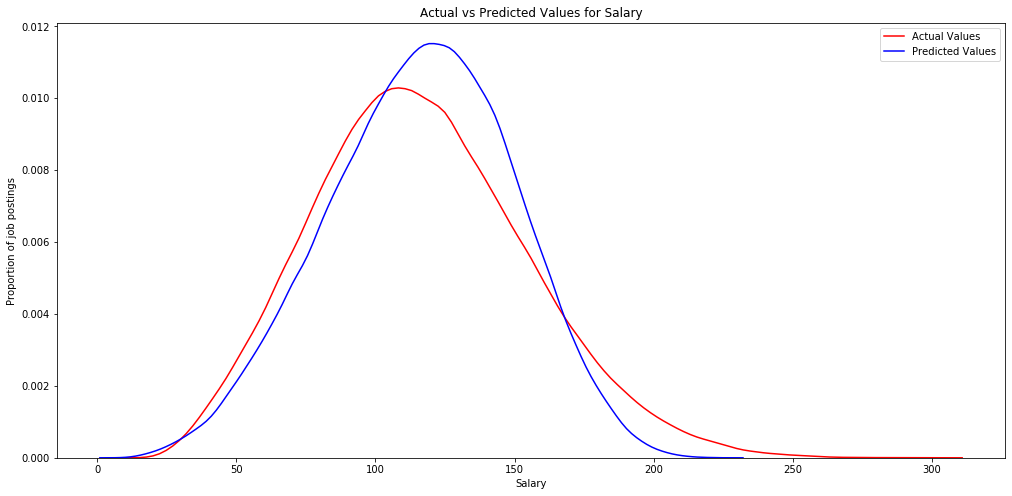

In [58]:
predict_plot(y_test, pred)


In [59]:
#calculate mse and compare it with the baseline mse value
mse_calc(MlinearRegression,df_features)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.8s finished


MSE: 384.41753861192296


# Random Forest

In [60]:
#importing the necessary library needed for a randomforestregressor
from sklearn.ensemble import RandomForestRegressor

In [61]:
# create a instance for the regressor
rfr = RandomForestRegressor(n_estimators=50,max_depth=25, min_samples_split=60,max_features='auto',n_jobs=-1)

In [62]:
#fitting the data to the training dataset
rfr.fit(X_train,y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=60,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [63]:
rfr_pred =rfr.predict(X_test)

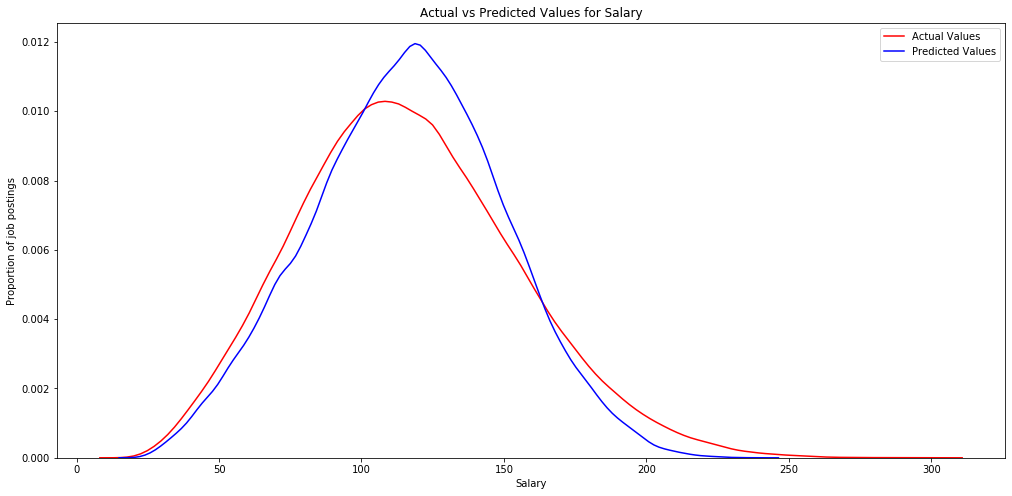

In [64]:
predict_plot(y_test, rfr_pred)


In [65]:
#calculate mse
mse_calc(rfr,df_features)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


MSE: 366.3172255368584


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.3min finished


### ---- 9 Test models ----

In [66]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [67]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [68]:
#importing pickle to save the model
import pickle

In [69]:
#since random forest provides the best result we use it is as our model
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=60,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [70]:
model.fit(df_features,df_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=60,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [71]:
#giving a filename
filename = 'model.pkl'

In [72]:
#dumping the model into the file
with open(filename,'wb') as file:
    pickle.dump(model,file)

In [73]:
#loading the model from the file
with open(filename,'rb') as file:
    loaded_model = pickle.load(file)

In [74]:
#get the score of the loaded model
score  = loaded_model.score(df_features,df_target)
print('Test score:', score)

Test score: 0.7844722293936717


In [76]:
#encoding the features of the test dataset and predicting the salary of the test dataset from the loaded model
test_feat = encode(test_data)
Predictions = loaded_model.predict(test_feat)

# Deploy Solution

In [77]:
#creating a new dataframe containing 2 columns and checking the first 5 rows
Predictions = pd.concat([test_data['jobId'],pd.DataFrame(Predictions,columns=['Predictions'])],axis=1)
Predictions.head()

,jobId,Predictions
0,JOB1362685407687,113.348581
1,JOB1362685407688,92.783188
2,JOB1362685407689,179.409156
3,JOB1362685407690,105.785081
4,JOB1362685407691,110.970306


In [78]:
#saving the predictions to a csv file
Predictions.to_csv('Predictions.csv')


Text(0, 0.5, 'Proportion of job postings')

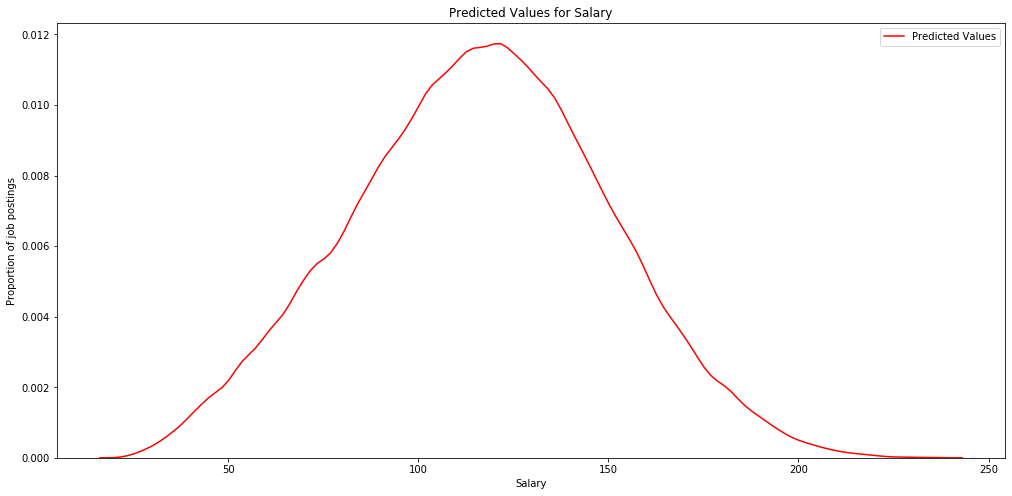

In [79]:
# a plot of distribution of predicted salaries
plt.figure(figsize=(17, 8))

Prediction_plot = sns.distplot(Predictions['Predictions'], hist=False, color="r", label="Predicted Values")

plt.title('Predicted Values for Salary')
plt.xlabel('Salary')
plt.ylabel('Proportion of job postings')

In [80]:
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature':df_features.columns,'importance':importances})
feature_importances.sort_values(by='importance',ascending=False,inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

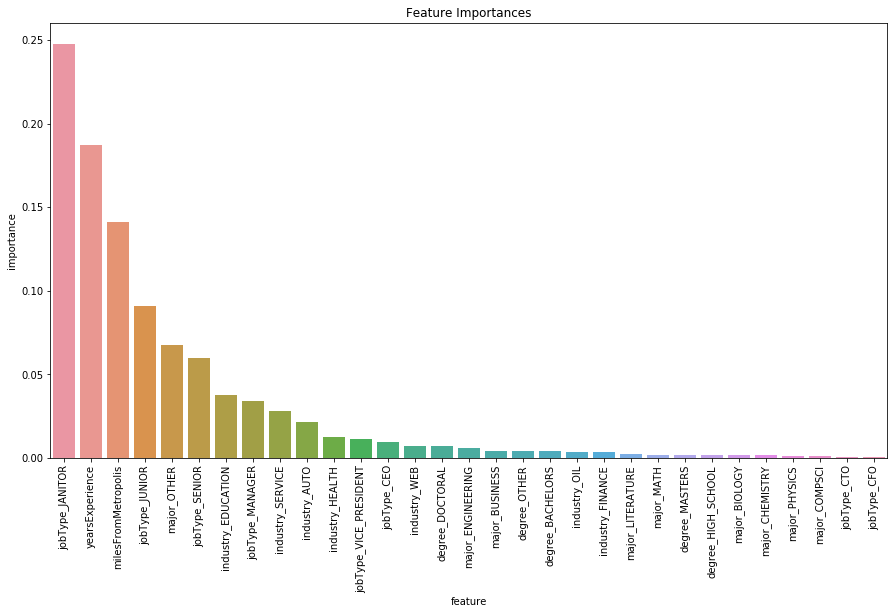

In [81]:
#A plot to visualze the importance of different features 
f, ax = plt.subplots(figsize=(15,8))
Feature_Importances = sns.barplot(x='feature',y='importance',data=feature_importances)
plt.title('Feature Importances')
plt.xticks(rotation=90)